In [103]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [104]:
df_driver_ids = pd.read_csv("driver_ids.csv")
df_ride_ids = pd.read_csv("ride_ids.csv")
df_ride_timestamps = pd.read_csv("ride_timestamps.csv")
print(df_driver_ids.columns)
print(df_ride_ids.columns)
print(df_ride_timestamps.columns)
df_ride_timestamps['timestamp']= pd.to_datetime(df_ride_timestamps['timestamp'])
df_driver_ids['driver_onboard_date']= pd.to_datetime(df_driver_ids['driver_onboard_date'])

# no na values except one timestamp

Index(['driver_id', 'driver_onboard_date'], dtype='object')
Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time'],
      dtype='object')
Index(['ride_id', 'event', 'timestamp'], dtype='object')


In [114]:
def fixMinMax(fare):
    if fare < 5:
        fare = 5
    if fare > 400:
        fare = 400
    return round(fare, 2)
def primeTimeX(value):
    if value > 0:
        return value/100
    else:
        return 1
df_ride_ids['primeMultiplicator'] = df_ride_ids['ride_prime_time'].map(primeTimeX)
df_ride_ids['fare'] = (3.75 + 1.15*(df_ride_ids['ride_distance']/1609) + 
                       0.22*(df_ride_ids['ride_duration']/60)) * (1 + df_ride_ids['primeMultiplicator'])
df_ride_ids['adjusted_fare'] = df_ride_ids['fare'].map(fixMinMax)
df_ride_ids.head(5)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,primeMultiplicator,fare,adjusted_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,0.50,9.365063,9.37
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,1.00,18.238509,18.24
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,1.00,16.386152,16.39
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,0.25,78.311286,78.31
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,1.00,19.417558,19.42


In [110]:
# ride data given is for every ride completed by driver, hence no cancelled rides
df_ride_whichMonth = df_ride_timestamps.copy(deep = True)
df_ride_whichMonth = df_ride_whichMonth.dropna(how = "any")
print(len(df_ride_whichMonth) - len(df_ride_timestamps))
df_ride_whichMonth['YearMonth'] = df_ride_whichMonth['timestamp'].apply(lambda x:x.strftime('%Y-%m')) # get year and month
print(df_ride_whichMonth['YearMonth'].unique())
df_ride_whichMonth = df_ride_whichMonth[df_ride_whichMonth['event'] == 'picked_up_at']


-1
['2016-06' '2016-05' '2016-04' '2016-03']


In [111]:
df_ride_whichMonth.head(5)
df_monthly_money = pd.merge(df_ride_ids, df_ride_whichMonth[['ride_id', 'YearMonth']],
                            left_on = 'ride_id', right_on = 'ride_id')
df_monthly_money = df_monthly_money[['driver_id', 'adjusted_fare', 'YearMonth']]
df_monthly_money.head(5)
df_monthly_money = pd.merge(df_monthly_money, df_driver_ids,
                           left_on = 'driver_id', right_on = 'driver_id')
df_monthly_money['driver_onboard_date']= pd.to_datetime(df_monthly_money['driver_onboard_date'])
df_monthly_money['onborad_YearMonth'] = df_monthly_money['driver_onboard_date'].apply(lambda x:x.strftime('%Y-%m'))
df_monthly_money.head(5)

,driver_id,adjusted_fare,YearMonth,driver_onboard_date,onborad_YearMonth
0,002be0ffdc997bd5c50703158b7c2491,5.00,2016-04,2016-03-29,2016-03
1,002be0ffdc997bd5c50703158b7c2491,10.12,2016-03,2016-03-29,2016-03
2,002be0ffdc997bd5c50703158b7c2491,9.19,2016-06,2016-03-29,2016-03
3,002be0ffdc997bd5c50703158b7c2491,15.91,2016-05,2016-03-29,2016-03
4,002be0ffdc997bd5c50703158b7c2491,10.71,2016-04,2016-03-29,2016-03


In [112]:
def month_number(d1):
    k = d1['onborad_YearMonth']
    j = d1['YearMonth']
    d1 = [int(i) for i in k.split('-')]
    d2 = [int(i) for i in j.split('-')]
    
    if d2[1] < d1[1]:
        return d2[1] + 12 - d1[1] + (d2[0] - d1[0] - 1)*12
    else:
        return (d2[0] - d1[0])*12 + d2[1] - d1[1]

df_monthly_money['month_number'] = df_monthly_money[['onborad_YearMonth','YearMonth']].apply(month_number, axis = 1)
df_monthly_money.head(5)
print(df_monthly_money['onborad_YearMonth'].unique())

['2016-03' '2016-04' '2016-05']


In [113]:
print(df_monthly_money.head(5))

                          driver_id  adjusted_fare YearMonth  \
0  002be0ffdc997bd5c50703158b7c2491           5.00   2016-04   
1  002be0ffdc997bd5c50703158b7c2491          10.12   2016-03   
2  002be0ffdc997bd5c50703158b7c2491           9.19   2016-06   
3  002be0ffdc997bd5c50703158b7c2491          15.91   2016-05   
4  002be0ffdc997bd5c50703158b7c2491          10.71   2016-04   

  driver_onboard_date onborad_YearMonth  month_number  
0          2016-03-29           2016-03             1  
1          2016-03-29           2016-03             0  
2          2016-03-29           2016-03             3  
3          2016-03-29           2016-03             2  
4          2016-03-29           2016-03             1  


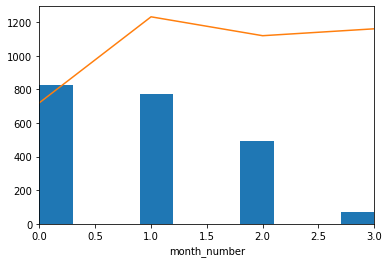

In [90]:
df_monthly_avgs = df_monthly_money.groupby(['driver_id', 'month_number'])['adjusted_fare'].agg("sum").reset_index()
df_monthly_avgs['month_number'].hist()
df_monthly_avgs.groupby('month_number')['adjusted_fare'].agg("mean").plot()

#### We have been given 3 months data, hence analysis needs to be granular at day level and then time level. So far we see that the data we have is between March 2016 - May 2016. Hence our analysis is about seeing the trends in a driver's productivity over these three months and elucidate what it will continue to be.

#### We can say that drivers don't saty for long, and maximum churn is between their second and third month. The problem with the histogram is that more no of drivers have the option of having their third month evaluated than not, because some drivers that join in May 2016 wouldn't have completed enough time to show up on the map. 

#### So we first see the no of drivers joining each month.

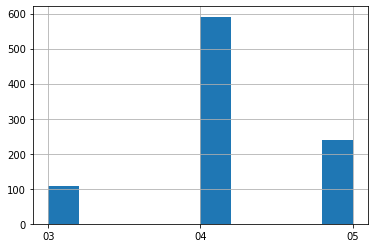

In [97]:
df_driver_ids_c = df_driver_ids.copy(deep = True)
df_driver_ids_c['onborad_month'] = df_driver_ids_c['driver_onboard_date'].apply(lambda x:x.strftime('%m'))

df_driver_ids_c['onborad_month'].hist()

In [222]:
df_ride_whichMonth = df_ride_timestamps.copy(deep = True)
df_ride_whichMonth = df_ride_whichMonth.dropna(how = "any")
df_ride_whichMonth = df_ride_whichMonth[df_ride_whichMonth['event'] == 'picked_up_at']
df_monthly_money = pd.merge(df_ride_ids, df_ride_whichMonth,
                            left_on = 'ride_id', right_on = 'ride_id')
df_monthly_money = pd.merge(df_driver_ids, df_monthly_money,
                            left_on = 'driver_id', right_on = 'driver_id')
df_daily_money =  df_monthly_money.copy(deep = True)

def getDeltaDays(val1):
    d1 = val1['timestamp']
    d2 = val1['driver_onboard_date']
    return (d1 - d2).days

df_daily_money['deltaDays'] = df_daily_money[['timestamp', 'driver_onboard_date']].apply(getDeltaDays, axis = 1)
print(df_daily_money.head(5))

                          driver_id driver_onboard_date  \
0  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
1  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
2  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
3  002be0ffdc997bd5c50703158b7c2491          2016-03-29   
4  002be0ffdc997bd5c50703158b7c2491          2016-03-29   

                            ride_id  ride_distance  ride_duration  \
0  006d61cf7446e682f7bc50b0f8a5bea5           1811            327   
1  01b522c5c3a756fbdb12e95e87507eda           3362            809   
2  029227c4c2971ce69ff2274dc798ef43           3282            572   
3  034e861343a63ac3c18a9ceb1ce0ac69          65283           3338   
4  034f2e614a2f9fc7f1c2f77647d1b981           4115            823   

   ride_prime_time  primeMultiplicator       fare  adjusted_fare  \
0               50                0.50   9.365063           9.37   
1                0                1.00  18.238509          18.24   
2                0        

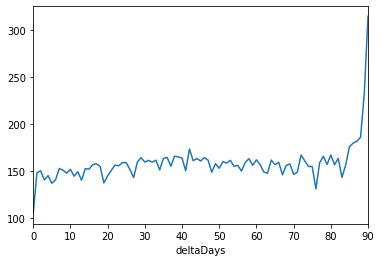

In [156]:
# df_daily_money.groupby(['driver_id', 'deltaDays'])['adjusted_fare'].agg("sum").reset_index().groupby('deltaDays')['adjusted_fare'].agg("mean")
df_daily_money.groupby(['driver_id', 'deltaDays'])['adjusted_fare'].agg("sum").reset_index().groupby('deltaDays')['adjusted_fare'].agg("mean").plot()

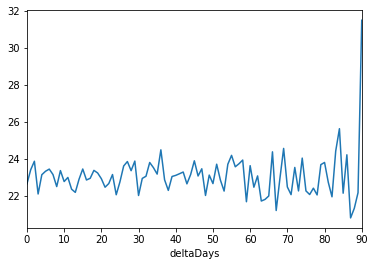

In [159]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['adjusted_fare'].agg("mean").reset_index().groupby('deltaDays')['adjusted_fare'].agg("mean").plot()

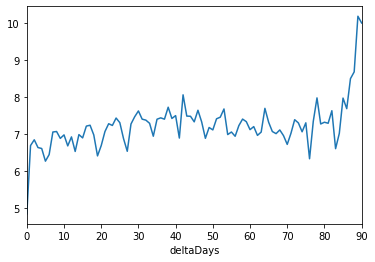

In [162]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['ride_prime_time'].count().reset_index().groupby('deltaDays')['ride_prime_time'].agg("mean").plot()

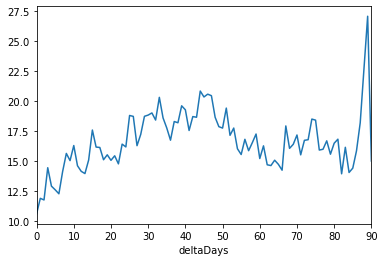

In [163]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['ride_prime_time'].agg("mean").reset_index().groupby('deltaDays')['ride_prime_time'].agg("mean").plot()

In [165]:
df_daily_money.groupby(['driver_id', 'deltaDays'])['deltaDays'].hist()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002308DBC5AE8> (for post_execute):


KeyboardInterrupt: 

In [ ]:
k = df_ride_timestamps['ride_id']
df = pd.DataFrame(k)
df = df.drop_duplicates()
df['requested_at'] = np.NaN
df['requested_at'] = pd.to_datetime(df['requested_at'])

df['accepted_at'] = np.NaN
df['accepted_at'] = pd.to_datetime(df['accepted_at'])
df['arrived_at'] = np.NaN

df['arrived_at'] = pd.to_datetime(df['arrived_at'])
df['picked_up_at'] = np.NaN
df['picked_up_at'] = pd.to_datetime(df['picked_up_at'])
df['dropped_off_at'] = np.NaN
df['dropped_off_at'] = pd.to_datetime(df['dropped_off_at'])
def applyEvent(event):
    
    k = pd.Series(df_ride_timestamps[(df_ride_timestamps['ride_id'] == event) &
                                     (df_ride_timestamps['event'] == 'requested_at')]['timestamp'].values,
                  index = ['requested_at'])
    
    k = k.append(pd.Series(df_ride_timestamps[(df_ride_timestamps['ride_id'] == event) & 
                            (df_ride_timestamps['event'] == 'accepted_at')]['timestamp'].values, index = ['accepted_at'])
                )
    
    k = k.append(pd.Series(df_ride_timestamps[(df_ride_timestamps['ride_id'] == event) & 
                            (df_ride_timestamps['event'] == 'arrived_at')]['timestamp'].values, index = ['arrived_at'])
                )
    
    k = k.append(pd.Series(df_ride_timestamps[(df_ride_timestamps['ride_id'] == event) & 
                            (df_ride_timestamps['event'] == 'picked_up_at')]['timestamp'].values, index = ['picked_up_at'])
                )
    
    k = k.append(pd.Series(df_ride_timestamps[(df_ride_timestamps['ride_id'] == event) & 
                            (df_ride_timestamps['event'] == 'dropped_off_at')]['timestamp'].values, index = ['dropped_off_at'])
                )
    
    return k

df[['requested_at', 'accepted_at', 'arrived_at', 'picked_up_at', 'dropped_off_at']] = df['ride_id'].apply(applyEvent)
print(df)